In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp
from scipy.special import kn
import astropy.constants as ct
import pandas as pd
from scipy.optimize import newton

In [2]:
# constants

vev = 246 # GeV - Higgs VEV
m_h = 125.2 # GeV - Higgs mass
Gamma_h = 4.07e-3 # GeV - total Higgs decay width
M_W = 80.3692 # GeV - W boson mass
M_Z = 91.188 # GeV - Z boson mass

m_e = 0.511e-3 # GeV - electron mass
m_muon = 105.66e-3 # GeV - muon mass
m_tau = 1.77693 # GeV - tau mass
m_u = 2.16e-3 # GeV - up mass
m_d = 4.7e-3 # GeV - down mass
m_c = 1.273 # GeV - charm mass
m_s = 93.5e-3 # GeV - strange mass
m_t = 172.57 # GeV - top mass
m_b = 4.183 # GeV - bottom mass

M_V = [M_W, M_Z]
M_f = [m_e,m_muon,m_tau,m_u,m_d,m_c,m_s,m_t,m_b]
n_cs = [1,1,1,3,3,3,3,3,3]

c_V = [1,1/2]

g_V = 3
g_f = 2

C = 0.349 # no sé qué es esto

gstar = 106.75
MP = 2.4e18
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3
gS = 1

In [3]:
SM_particles = pd.DataFrame(index=['h','W','Z','e','mu','tau','u','d','c','s','t','b'])
SM_particles['mass'] = np.array([m_h,]+M_V+M_f)
SM_particles['spin'] = np.array([0,1,1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
SM_particles['n_c'] = np.array([1,1,1,1,1,1,3,3,3,3,3,3])
SM_particles['dof'] = 2*SM_particles['spin']+1

In [4]:
def sigma(w,M_S,lambda_HS,initial_particle):
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        A_ = g**-2*lambda_HS**2/(32*M**2*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)+0j)**0.5
        C_ = ((2*np.tan(w)+1)/(4*np.tan(w)-1))**2
        return (A_*B_*C_).real
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        A_ = g**-2*lambda_HS**2*M**2/(32*np.pi*np.tan(w))
        B_ = ((np.tan(w)-M_S**2/M**2)/(np.tan(w)-1)+0j)**0.5
        C_ = (4*np.tan(w)**2-4*np.tan(w)+3)/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real
    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        A_ = g**-2*lambda_HS**2*M**2/(16*np.pi*np.tan(w)*n)
        B_ = ((np.tan(w)-M_S**2/M**2)*(np.tan(w)-1)+0j)**0.5
        C_ = 1/((4*M**2*np.tan(w)-m_h**2)**2+m_h**2*Gamma_h**2)
        return (A_*B_*C_).real
    
def Gamma_hSS(lambda_HS,M_S):
    return (lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2+0j)**0.5).real


In [9]:
def Omegah2(M_S,lambda_HS,channel):
    def Boltz_eq(x):
        HMS = (np.pi**2*gstar/90)**0.5*M_S**2/MP
        sMS = 2*np.pi**2/45*gstar*M_S**3
        if channel == 'all':
            suma = 0
            for part in SM_particles.index:
                M = SM_particles.loc[part]['mass']
                g = SM_particles.loc[part]['dof']
                integrand = lambda w: ((np.tan(w)-1)*np.tan(w)**0.5/(np.cos(w)**2)*sigma(w,M_S,lambda_HS,part)*kn(1,2*M/M_S*np.tan(w)**0.5*x)).real
                res = quad(integrand,np.pi/4+1e-5,np.pi/2-1e-5)[0]
                suma += (g**2/np.pi**4)*M_S*M**5/x*res
    
        return x**4/(HMS*sMS)*(suma+C*m_h**2*M_S/(2*np.pi**2*x)*Gamma_hSS(lambda_HS,M_S)*kn(1,m_h/M_S*x))
    Y = quad(Boltz_eq,0,np.inf)[0]
    return s0*M_S*Y/(3*MP**2*(1.45e-42)**2)*0.68**2

Omegah2 = np.vectorize(Omegah2)

In [14]:
mm = np.logspace(0,4)
ll = np.logspace(-13,-10,10)
MM, LL = np.meshgrid(mm,ll)


In [15]:
Omegah2(1,10**-10.5,'all')

array(0.1102869)

In [16]:
OO = Omegah2(MM,LL,'all')

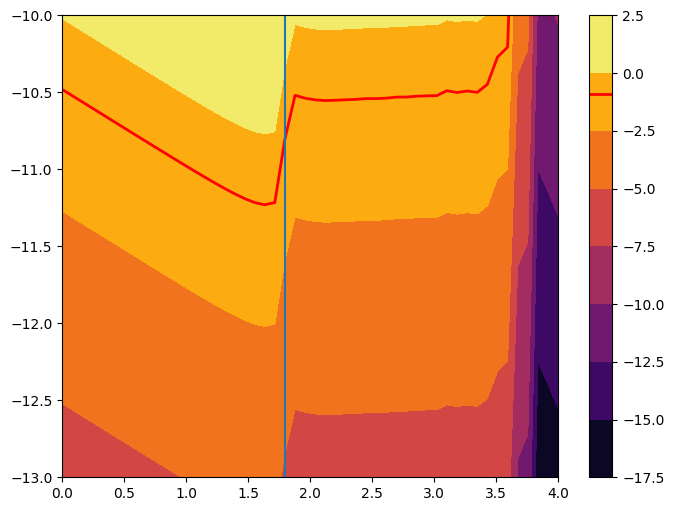

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contourf(np.log10(MM),np.log10(LL),np.log10(OO),cmap='inferno',)
CSl = ax.contour(CS,levels=[np.log10(0.12),],colors='red',linestyles='solid',linewidths=2)
ax.vlines(np.log10(m_h/2),-13,-10)
cbar = fig.colorbar(CS)
cbar.add_lines(CSl)